# Feasability study for products classification

In this notebook we will evaluate the possibility to have a clusterization by text. \
We aim to create a model that will cluster the products in the same way they are naturally clusturized. This would mean that the classification of product can be done by machine learning. 

In [3]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize

In [4]:
data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
data.shape

(1050, 15)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Now the question is : what categories will we use to clusturize products by type ? Surely we will need to focus on text description, name, and the like

The "product_name" category seems essential \
The "category_tree" looks very promising due to its name \
The "description" sounds good, but it depends on what _type_ of description we are talking about. A commercial description could alter our results \
The "product_specifications" looks interesting as well. A dictionnary in which the function ("key"=>"Designed For") is given sounds interesting

In [7]:
data.product_name.loc[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain'

By observing the "product_category_tree" columns, we face another question : how far do we want to be specific ? The general category ? Or the n-x subcategory ? \
We will use the general category only

In [9]:
data['general_category'] = data['product_category_tree'].map(lambda x: x.strip('["]').split(' >> ')[0])
data['general_category'].head(5)

0    Home Furnishing
1          Baby Care
2          Baby Care
3    Home Furnishing
4    Home Furnishing
Name: general_category, dtype: object

In [10]:
data['general_category'].nunique()

7

We have a total of 7 categories

### The client wants an analysis on image and _description_
We will therefore base our feasability research on the "description" category \
Seems foolish not to include the name tho ...

In [13]:
data.description

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

## Text pre_treatment

In [15]:
# nltk package installer
# nltk.download('all')

In [16]:
# To understand what we are dealing with, let's see the first description
desc = data.description[0]
desc

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [17]:
'''
# let's define a function to clean the sentence
def sentence_cleaner(sentence):
    sentence_cleaned = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('(', ' ').replace(')', ' ')
    return sentence_cleaned

x = sentence_cleaner(desc)
x
# The second approach with RegExp seems mor efficient than this one
'''

"\n# let's define a function to clean the sentence\ndef sentence_cleaner(sentence):\n    sentence_cleaned = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('(', ' ').replace(')', ' ')\n    return sentence_cleaned\n\nx = sentence_cleaner(desc)\nx\n# The second approach with RegExp seems mor efficient than this one\n"

In [18]:
# define a RegExp to tokenize only alphanumerics
tokenizer = nltk.RegexpTokenizer(r'\w+')
list_of_words = tokenizer.tokenize(desc)
#list_of_words

In [19]:
# lower all characters
lowered_list = [w.lower() for w in list_of_words]
#lowered_list
#len(lowered_list)

In [20]:
# stopwords exploration
len(nltk.corpus.stopwords.words('english'))

179

In [21]:
# stopwords suppression
def stop_word_filter(list_words) :
    stop_w = nltk.corpus.stopwords.words('english')
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

In [22]:
filtered_list = stop_word_filter(lowered_list)
#filtered_list
#len(filtered_list)

Description has been normalized by suppressing anything other than alphanumerics, lowering case, suppressing stopwords

### Stem / lemmat
Now it's time to stem / lemmatize our list of words

General opinion is that Stemming outperforms Lemmatization. \
We will prepare both anyway and retain the best-performing one

In [25]:
# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer
# Stemmer (Porter)
from nltk.stem.porter import PorterStemmer

In [26]:
def lemmat(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

In [27]:
lemmat_list = lemmat(filtered_list)
#lemmat_list
#len(lemmat_list)

In [28]:
def stemmer(list_words) : 
    stem = PorterStemmer()
    stem_w = [stem.stem(w) for w in list_words]
    return stem_w

In [29]:
stem_list = stemmer(filtered_list)
#stem_list

In [30]:
transf_desc_text = ' '.join(stem_list)
transf_desc_text

'key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain 213 height pack price 899 curtain enhanc look interior curtain made 100 high qualiti polyest fabric featur eyelet style stitch metal ring make room environ romant love curtain ant wrinkl anti shrinkag eleg appar give home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlight specif eleg polyest multicolor abstract eyelet door curtain 213 height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model duster25 color multicolor dimens length 213 box number content sale packag pack sale packag curtain bodi design materi polyest'

In [31]:
# Define a treatment function that will be usable on the whole dataset

def cleaning_description_stemmed(description) :
    # Tools used reminder :
    # tokenizer = nltk.RegexpTokenizer(r'\w+')
    # stop_w = nltk.corpus.stopwords.words('english')
    # lemmatizer = WordNetLemmatizer()
    # stem = PorterStemmer()
    
    list_of_words = tokenizer.tokenize(description)
    lowered_list = [w.lower() for w in list_of_words]
    filtered_list = stop_word_filter(lowered_list)
    #lemmat_list = lemmat(filtered_list)
    stemmed_list = stemmer(filtered_list)
    transformed_desc = ' '.join(stemmed_list)

    return transformed_desc

In [32]:
# Create a new column with all description cleaned

data['cleaned_desc_stem'] = data['description'].apply(lambda x : cleaning_description_stemmed(x))

In [33]:
data['cleaned_desc_stem'][1049]

'buy uberlyf larg vinyl sticker 595 onlin uberlyf larg vinyl sticker best price free ship cash deliveri genuin product day replac guarante'

lemmat => tfidf + stem => tfidf \
Faire les deux approches séparement pour comparer les résultats

## Bag Of Word

In [36]:
# How important is the bag of word ?

x = data['cleaned_desc_stem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", x)

max length bow :  0       152
1        62
2       154
3       112
4       150
       ... 
1045    224
1046    152
1047     30
1048     24
1049     22
Name: cleaned_desc_stem, Length: 1050, dtype: int64


In [37]:
# création des bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

cv_fit = cvect.fit(data['cleaned_desc_stem'])
ctf_fit = ctf.fit(data['cleaned_desc_stem'])

cv_transform = cvect.transform(data['cleaned_desc_stem'])  
ctf_transform = ctf.transform(data['cleaned_desc_stem'])  

In [38]:
cv_transform

<1050x4679 sparse matrix of type '<class 'numpy.int64'>'
	with 33327 stored elements in Compressed Sparse Row format>

In [39]:
ctf_transform

<1050x4679 sparse matrix of type '<class 'numpy.float64'>'
	with 33327 stored elements in Compressed Sparse Row format>

We obviously have a lot of different words throughout the entire corpus of description \
We may want to reduce this number

### Fitting on the name to reduce number of words seen during training

In [42]:
# Clean the product_name first
data['cleaned_name'] = data['product_name'].apply(lambda x : cleaning_description_stemmed(x))

# Create a feature composed of name and description
data['to_bow_clean'] = data['cleaned_name'] +' '+ data['cleaned_desc_stem']

In [43]:
cv_fit_2 = cvect.fit(data['cleaned_name'])
ctf_fit_2 = ctf.fit(data['cleaned_name'])

cv_transform_2 = cvect.transform(data['to_bow_clean'])  
ctf_transform_2 = ctf.transform(data['to_bow_clean'])

In [44]:
cv_transform_2

<1050x2064 sparse matrix of type '<class 'numpy.int64'>'
	with 17795 stored elements in Compressed Sparse Row format>

In [45]:
ctf_transform_2

<1050x2064 sparse matrix of type '<class 'numpy.float64'>'
	with 17795 stored elements in Compressed Sparse Row format>

We reduced the number of words seen during training from 4676 to 2064

tester ACP + TSNE sur BoW \
tester TSNE solo \
l'ACP est justifiable si la TSNE est trop longue 

### PCA

In [49]:
# PCA to reduce dimensions

from sklearn.decomposition import PCA

pca = PCA(svd_solver='arpack')
pca.fit(ctf_transform_2)

PCA(svd_solver='arpack')

In [50]:
# how many components needed to explain 80% of variance
x = (pca.explained_variance_ratio_*100).round(2).cumsum()
y = np.where(x>=80)[0][0]
y

368

PCA tells us that 80% of variance is explained by 369 features \
We can now reduce to this amount of features

In [52]:
pca = PCA(n_components=y+1, svd_solver='arpack')
reduced_ctf_transform_2 = pca.fit_transform(ctf_transform_2)

In [53]:
reduced_ctf_transform_2.shape

(1050, 369)

### TSNE

In [55]:
# T-SNE to reduce dimensions

from sklearn.manifold import TSNE

tsne = TSNE(init='random')

embedded_ctf_transform_2 = tsne.fit_transform(reduced_ctf_transform_2)
embedded_ctf_transform_2.shape

C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


(1050, 2)

In [56]:
embedded_ctf_transform_2

array([[-12.09073 ,  40.35189 ],
       [ 22.455534,  25.635073],
       [ 25.988974,  24.726755],
       ...,
       [ 10.632078, -19.16291 ],
       [ 10.793554, -16.652754],
       [ 10.932757, -18.433125]], dtype=float32)

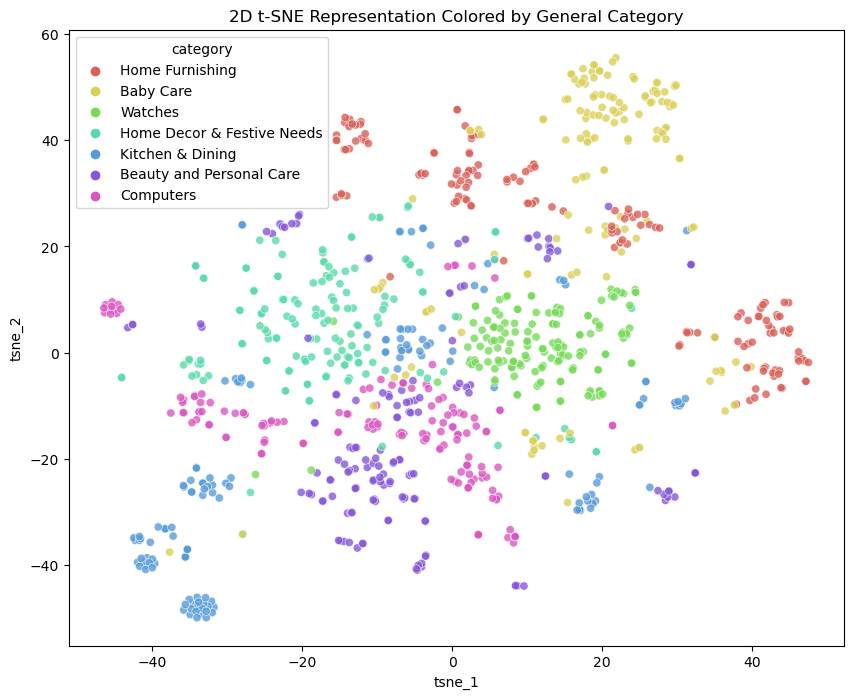

In [57]:
general_categories = data['general_category']

df_real_categories = pd.DataFrame({
    'tsne_1': embedded_ctf_transform_2[:, 0],
    'tsne_2': embedded_ctf_transform_2[:, 1],
    'category': general_categories
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2', 
    hue='category',
    palette=sns.color_palette('hls', len(df_real_categories['category'].unique())),
    data=df_real_categories,
    legend='full',
    alpha=0.8
)
plt.title('2D t-SNE Representation Colored by General Category')
plt.show()

## Clustering via K-means

In [59]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=100 ,random_state=42, init='k-means++')
kmeans.fit(embedded_ctf_transform_2)

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


KMeans(n_clusters=7, n_init=100, random_state=42)

In [60]:
data['clustering'] = kmeans.predict(embedded_ctf_transform_2)
data['clustering'].head()

0    2
1    3
2    3
3    2
4    2
Name: clustering, dtype: int32

In [61]:
df_clustering = pd.DataFrame({
    'tsne_1': embedded_ctf_transform_2[:, 0],
    'tsne_2': embedded_ctf_transform_2[:, 1],
    'clusters': data['clustering']
})

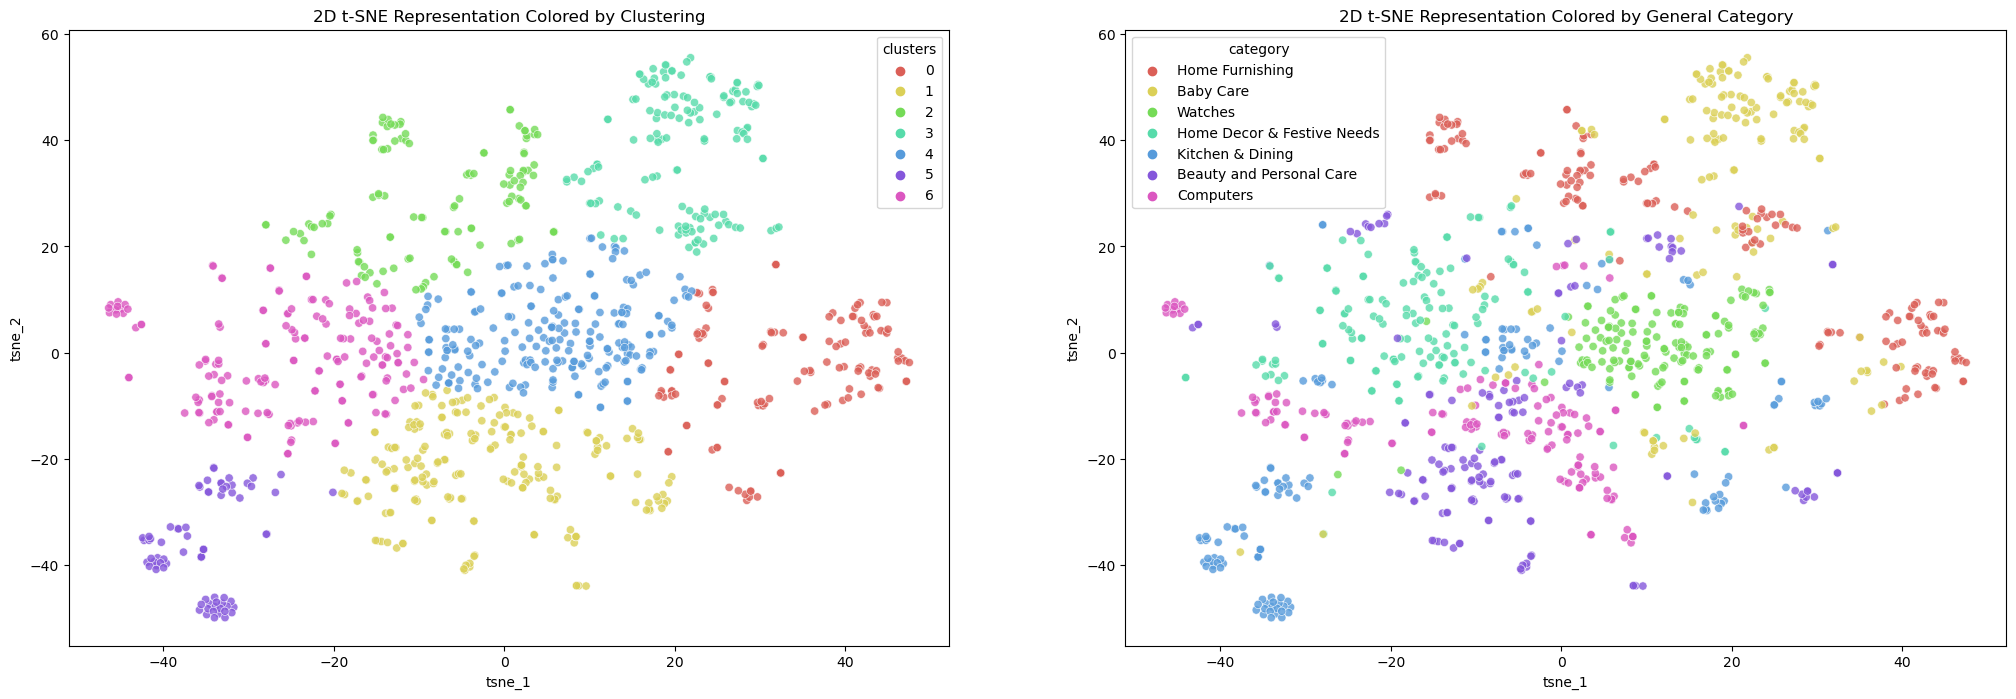

In [62]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.scatterplot(
    ax=ax[1],
    x='tsne_1', y='tsne_2',
    hue='category',
    palette=sns.color_palette('hls', len(df_real_categories['category'].unique())),
    data=df_real_categories,
    legend='full',
    alpha=0.8
)
ax[1].set_title('2D t-SNE Representation Colored by General Category')

sns.scatterplot(
    ax=ax[0],
    x='tsne_1', y='tsne_2',
    hue='clusters',
    palette=sns.color_palette('hls', len(df_clustering['clusters'].unique())),
    data=df_clustering,
    legend='full',
    alpha=0.8
)
ax[0].set_title('2D t-SNE Representation Colored by Clustering')


plt.show()

In [63]:
from sklearn.metrics.cluster import adjusted_rand_score

ari_clustering = adjusted_rand_score(data['general_category'], data['clustering'])

print(ari_clustering)

0.3174178825367656


ARI of 0.376 (drops to 0.35 when t-sne is performed on PCAd data) \
It seems unsatisfaying to validate an automated classification. \
Maybe text features weren't prepared well enough ? Tf-IDF ill adapted to our case ?

## Advanced techniques : Word2Vec, BERT, USE

### Word2Vec

In [66]:
# need to rework from data['to_bow_clean']
data['bow_cleaned_list'] = data['to_bow_clean'].to_list()

In [96]:
# librairies for NLP
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import gensim

In [73]:
sentences = data['bow_cleaned_list']
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [141]:
# params
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen=20

In [142]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4030
Word2Vec trained


In [143]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4031


In [144]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4031, 300)


In [145]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

C:\Users\kanam\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 20, 300)             │       1,209,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,300 (4.61 MB)

 Trainable params: 1,209,300 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(1050, 300)

In [147]:
## Clustering with embedding

kmeans = KMeans(n_clusters=7, n_init=100 ,random_state=42, init='k-means++')
kmeans.fit(embeddings)
data['clustering_w2v'] = kmeans.predict(embeddings)

print(adjusted_rand_score(data['general_category'], data['clustering_w2v']))

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


0.28054001068140616


Word2Vec is WORSE than tf-idf ???

### BERT